# TD 3 | Étude de la marge EGT d'un turboréacteur

---

Objectifs du TD :

* pratiquer sur un premier use case concret d'analyse de données de moteurs d'avion
* fonctions glissantes pandas (_rolling_)
* régression linéaire

---

La table fournie contient les données moteurs disposant de l'information "marge EGT" (egthdm) issue
des rapports ACARS. Il s'agit donc uniquement de rapports extraits au décollage (TAKEOFF). On a
récupéré l'ensemble des rapports des moteurs livrés depuis avril 2016.

## 1. Chargement et nettoyage des données

#### 1.1. Chargez les données ACARS à l'aide de la méthode pandas `read_excel`. Explorez les propriétés générales du jeu de données.

Fichier de données : `./data/accars_b.xlsx`.

In [ ]:
!git clone https://github.com/MadaneA/MACS3-Statistiques-Descriptives-TDs.git

In [1]:
import os
os.listdir("../data")

['accars_b.xlsx',
 'Rouet_geometries.csv',
 'Rouet_vibrations.csv',
 'Vol001.csv',
 'Vol002.csv',
 'Vol003.csv',
 'Vol004.csv',
 'Vol005.csv',
 'Vol006.csv',
 'Vol007.csv',
 'Vol008.csv',
 'Vol009.csv',
 'Vol010.csv']

In [2]:
import pandas as pd
acars = pd.read_excel('../data/accars_b.xlsx')
acars.head()

ModuleNotFoundError: No module named 'pandas'

In [2]:
acars.shape

(46621, 50)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

#### 1.2. Y a-t-il des valeurs manquantes ? Si oui, décrivez leur répartition et affichez le nombre de valeurs manquantes par colonne sous forme d'un bar plot.

<BarContainer object of 50 artists>

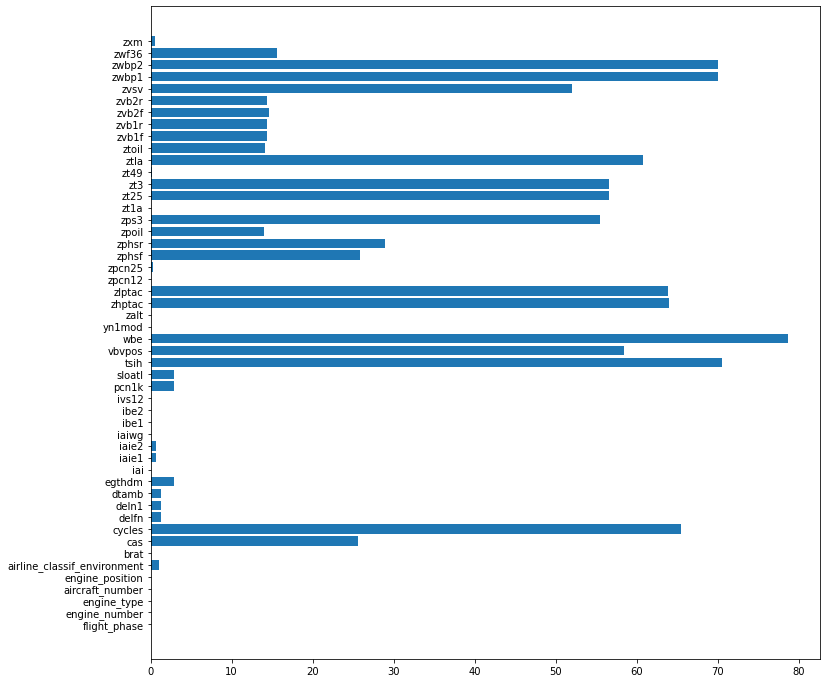

In [4]:
missing = acars.isna().mean()*100
fig,ax = plt.subplots(figsize=(12,12))
ax.barh(np.arange(missing.size), missing, tick_label=missing.index.tolist())

#### 1.3. Ne gardez que les lignes où le nombre de cycles (variable `cycles`) et la marge EGT (variable `egthdm`) sont présentes.

In [5]:
acars_clean = acars[~acars['egthdm'].isna() & ~acars['cycles'].isna()]
# ~A & ~B = ~(A | B)
acars_clean.shape

(15374, 50)

#### 1.4. Affichez les différents types de moteurs (indice : utilisez la méthode `unique()`).

In [6]:
acars_clean['engine_type'].unique()

array([10,  5,  7], dtype=int64)

#### 1.5. Sélectionnez uniquement les moteurs de type 10. Combien y a-t-il d'avions distincts ? Combien de vols par avion ? (attention : il y a 2 moteurs sur un avion)

In [7]:
type10 = acars_clean[acars_clean['engine_type'] == 10]
type10.shape

(712, 50)

In [8]:
type10['aircraft_number'].unique()

array([192,  14,  11, 190, 191], dtype=int64)

In [9]:
type10.groupby('aircraft_number').size()//2 # on peut aussi utiliser "count()", mais celle-ci s'applique à toutes les colonnes, et ne compte pas les NaN !

aircraft_number
11      17
14      97
190    110
191      6
192    126
dtype: int64

## 2. Étude de la marge EGT de l'avion 190

#### 2.1. Récupérez les variables `engine_number`, nombre de cycles (`cycles`) et marge EGT (`egthdm`) pour l'avion identifié par le numéro 190.

In [10]:
ac190 = type10[type10['aircraft_number'] == 190][['engine_number', 'cycles', 'egthdm']]
ac190.shape

(220, 3)

In [11]:
ac190['engine_number'].unique()

array([179, 180], dtype=int64)

In [12]:
ac190.head()

,engine_number,cycles,egthdm
11398,179,98.0,52.0118
11399,180,69.0,57.6415
11400,180,75.0,48.7217
11755,179,0.0,37.6572
11756,179,1.0,37.2208


#### 2.2. Affichez la courbe de l'évolution de la marge EGT au cours du temps pour les deux moteurs de l'avion, sur deux graphes séparés et en prenant soin d'ajouter des légendes.

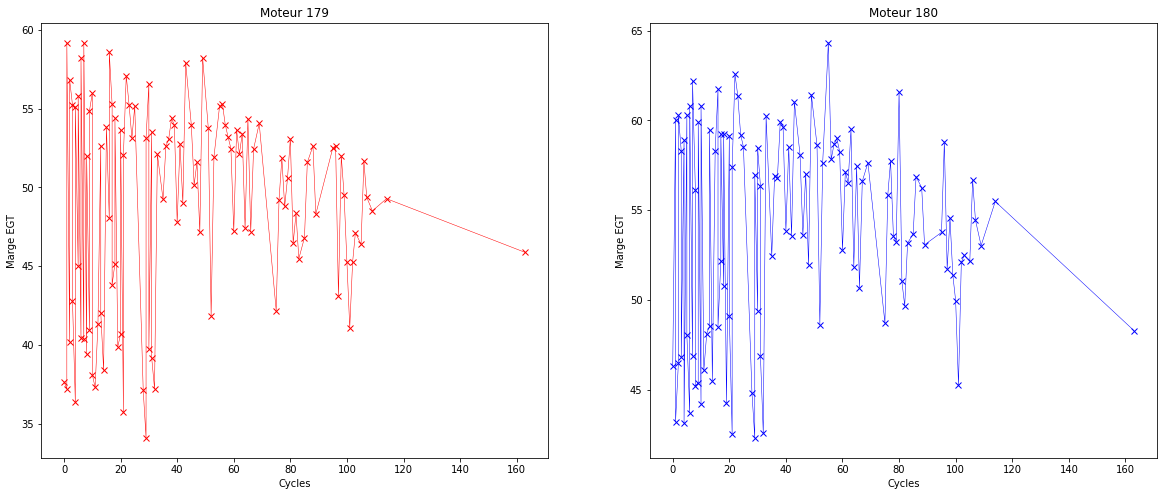

In [13]:
fig,ax = plt.subplots(1, 2, figsize=(20,8))
moteur179 = ac190[ac190['engine_number'] == 179].sort_values('cycles')
moteur180 = ac190[ac190['engine_number'] == 180].sort_values('cycles')
ax[0].plot(moteur179['cycles'], moteur179['egthdm'], 'rx-', linewidth=0.5)
ax[0].set_title('Moteur 179')
ax[1].plot(moteur180['cycles'], moteur180['egthdm'], 'bx-', linewidth=0.5)
ax[1].set_title('Moteur 180')
for i in [0,1]:
    ax[i].set_xlabel('Cycles')
    ax[i].set_ylabel('Marge EGT')

#### 2.3. Pour la suite, on ne s'intéresse qu'au moteur 179. Quel est le nombre de vols manquant dans les données ?

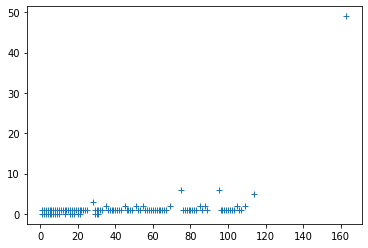

In [14]:
plt.plot(moteur179['cycles'], moteur179['cycles'].diff(1), '+')

In [15]:
sauts = moteur179['cycles'].diff() > 1
(moteur179['cycles'].diff(1) - 1).where(sauts).sum()

73.0

In [16]:
moteur179.tail()

,engine_number,cycles,egthdm
28386,179,106.0,51.6519
36515,179,107.0,49.3682
42808,179,109.0,48.5079
29636,179,114.0,49.2813
46111,179,163.0,45.8711


#### 2.4. Nettoyage de la marge EGT

On constate que sur un même cycle, il peut y avoir 2 valeurs de la variable `egthdm` mesurées. On ne souhaite garder que la plus grande des deux, et avoir une seule ligne par cycle, afin que l'on puisse utiliser le nombre de cycles comme index. Enfin, on veut compléter l'index pour les vols manquants, en remplissant les lignes par `NaN`. Pour cela, effectuez l'exercice suivant:

1. Utilisez une aggrégation pour obtenir la plus grande valeur à chaque cycle et stockez le résultat dans une Series pandas appelée 'egt'.
2. Ré-indexez le DataFrame pour avoir une ligne pour tout nombre de cycles (indice : passez par la méthode reindex).

In [17]:
egt = moteur179.groupby('cycles')['egthdm'].max()
egt = egt.reindex(pd.RangeIndex(0, egt.index.max()+1), axis='index')

In [18]:
egt.tail()

159        NaN
160        NaN
161        NaN
162        NaN
163    45.8711
Name: egthdm, dtype: float64

#### 2.5. On souhaite lisser les valeurs et se débarasser des outliers à l'aide d'une médiane glissante sur 15 cycles. Affichez sur un même graphe la marge EGT brute (points) et la marge lissée (ligne).
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.rolling.html#pandas.Series.rolling

Utilisez une fenêtre glissante de taille 15 cycles, avec un minimum de 3 observations non-nulles par fenêtre (paramètre `min_periods`).

Text(0.5, 1.0, 'Marge EGT et médiane glissante sur 15 cycles')

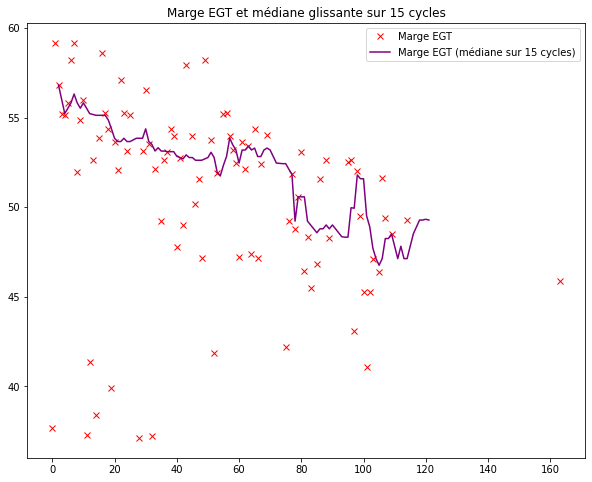

In [19]:
egtm = egt.rolling(window=15, min_periods=3).median().dropna()
plt.figure(figsize=(10,8))
plt.plot(egt.index, egt, 'rx')
plt.plot(egtm.index, egtm, '-', c='purple')
plt.legend(['Marge EGT', 'Marge EGT (médiane sur 15 cycles)'])
plt.title('Marge EGT et médiane glissante sur 15 cycles')

#### 2.6. Nettoyage de la marge EGT lissée

La marge EGT ne peut être que décroissante, sauf en cas de nettoyage moteur (waterwash) ou peut-être à cause d'éléments extérieurs, on va donc éviter de tenir compte des remontées de marge et ne prendre en considération que les points descendants. Cette estimation est pessimiste mais évite de prendre en compte ces facteurs extérieurs.

1. Calculez une série ne contenant que les valeurs décroissantes de la amrge EGT lissée.
2. Sur le graphique précédent, ajoutez ces points par-dessus la courbe.

In [20]:
egtm_decreasing = egtm.rolling(window=egtm.size, min_periods=1).min().drop_duplicates()

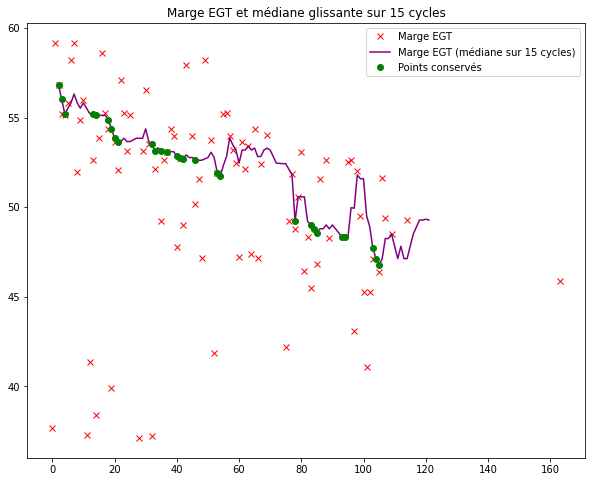

In [21]:
plt.figure(figsize=(10,8))
plt.plot(egt.index, egt, 'rx')
plt.plot(egtm.index, egtm, '-', c='purple')
plt.plot(egtm_decreasing.index, egtm_decreasing, 'o', c='g')
plt.legend(['Marge EGT', 'Marge EGT (médiane sur 15 cycles)', 'Points conservés'])
plt.title('Marge EGT et médiane glissante sur 15 cycles');

#### 2.7. Estimation de la pente de la marge EGT

La pente de la marge EGT est un indicateur très intéressant de l'usure du moteur. On l'estime par régression linéaire par rapport au nombre de cycles. Pour cela, on utilise les points conservés précédemment qui constituent une estimation pessimiste.

Pour la régression linéaire, on utilisera le modèle `LinearRegression` de scikit-learn. Son utilisation est similaire aux autres modèles de scikit-learn :
```python
lr = LinearRegression()
model = lr.fit(X, y)
```

1. Apprenez un modèle `LinearRegression` sur les données calculées précédemment. Affichez les coefficients et l'ordonnée à l'origine (_intercept_) du modèle obtenu. Les valeurs sont-elles cohérentes ? (indices : pour passer d'un objet pandas (DataFrame ou Series) à un array numpy, utilisez la propriété `values`)
2. Tracez la droite obtenue sur le graphe précédent.

In [22]:
from sklearn.linear_model import LinearRegression

In [23]:
egtm_decreasing.index.values, egtm_decreasing.values

(array([  2,   3,   4,  13,  14,  18,  19,  20,  21,  32,  33,  35,  37,
         40,  41,  42,  46,  53,  54,  78,  83,  84,  85,  93,  94, 103,
        104, 105], dtype=int64),
 array([56.8104 , 56.01835, 55.2263 , 55.1773 , 55.1283 , 54.8652 ,
        54.3729 , 53.8463 , 53.6643 , 53.4997 , 53.136  , 53.13185,
        53.0965 , 52.8421 , 52.7705 , 52.6947 , 52.6189 , 51.9282 ,
        51.7624 , 49.2196 , 49.0059 , 48.7922 , 48.5717 , 48.3512 ,
        48.32415, 47.7124 , 47.1277 , 46.7555 ]))

In [24]:
lr = LinearRegression(n_jobs=-1)
model = lr.fit(egtm_decreasing.index.values.reshape(-1,1), egtm_decreasing.values)

In [25]:
model.intercept_, model.coef_

(56.185555728145275, array([-0.08609514]))

C:\Users\33755\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


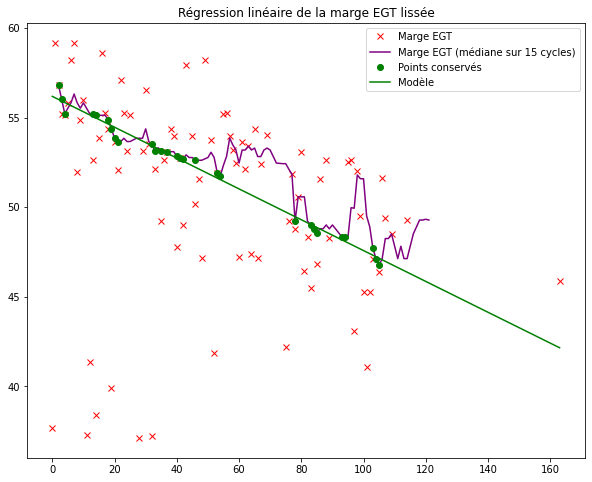

In [26]:
plt.figure(figsize=(10,8))
plt.plot(egt.index, egt, 'rx')
plt.plot(egtm.index, egtm, '-', c='purple')
plt.plot(egtm_decreasing.index, egtm_decreasing, 'go')
plt.plot([0, egt.index[-1]], [model.intercept_, model.predict(np.array(egt.index[-1]).reshape(-1, 1))], 'g-')
plt.legend(['Marge EGT', 'Marge EGT (médiane sur 15 cycles)', 'Points conservés', 'Modèle'])
plt.title('Régression linéaire de la marge EGT lissée');

### 3. Écriture d'une fonction de calcul de la pente EGT pour tous les moteurs

Tout d'abord, bravo si vous êtes arrivés jusque là ! Toutes les opérations que l'on a effectuées ont permis d'estimer la pente de la marge EGT du moteur 179 de l'avion 190 de type 10, et donc son usure. Maintenant, on souhaite répéter ce processus sur tous les moteurs ! Pour cela, il faudra créer une fonction Python générique, prenant en entrée l'ensemble du jeu de données ACARS et produisant en sortie l'ensemble des pentes/intercept des modèles de régression linéaire appris pour chaque moteur.

L'un des intérêts est de pouvoir prédire l'usure des moteurs, après un nombre de cycles donné.

Voici le squelette de la fonction à écrire (en ré-utilisant et adaptant tout les morceaux de code précédents) :

```python
def regress_egt_margin(df_acars):
    ...
    return df_regress_models # Contient les pentes et intercept pour tous les moteurs
```

In [27]:
def regress_egt_margin(df_acars):
    # Supression des valeurs manquantes
    acars_clean = df_acars[~df_acars['egthdm'].isna() & ~df_acars['cycles'].isna()]
    # Sélection des variables 
    acars_final = acars_clean[['engine_type', 'aircraft_number', 'engine_number', 'cycles', 'egthdm']]
    # Conversion des colonnes en entiers (int)
    for col in ['engine_type', 'aircraft_number', 'engine_number', 'cycles']:
        acars_final[col] = acars_final[col].apply(int)
    
    # Fonction à appliquer sur l'ensemble des vols de chaque moteur
    def process_engine(engine):
        # Récupération des identifiants du groupe de vols
        engine_type, aircraft_number, engine_number = engine.iloc[0]['engine_type'], engine.iloc[0]['aircraft_number'], engine.iloc[0]['engine_number']
        """
        print('Engine type:', engine_type)
        print('Aircraft number:', aircraft_number)
        print('Engine number:', engine_number)
        print(engine.shape)
        """
        # Préparation de la marge EGT
        egt = engine.sort_values('cycles')\
                    .groupby('cycles')['egthdm'].max()

        egt = egt.reindex(pd.RangeIndex(0, egt.index.max()+1), axis='index')
    
        # Calcul de la médiane glissante
        egtm = egt.rolling(window=15, min_periods=1).median().dropna()
        #
        egtm_decreasing = egtm.rolling(window=egtm.size, min_periods=1).min().drop_duplicates()
        
        # Si la résultat est vide (pas assez de vols), on renvoie des NaNs
        if not egtm.shape[0] > 0:
            return pd.DataFrame({'engine_type': engine_type, 'aircraft_number': aircraft_number, 'engine_number': engine_number, 
                                 'intercept': np.nan, 'coef': np.nan}, index=[engine_number])
        # Sinon, on effectue la régression linéaire
        else:
            
            lr = LinearRegression()
            model = lr.fit(egtm_decreasing.index.values.reshape(-1,1), egtm_decreasing.values)

            return pd.DataFrame({'engine_type': engine_type, 'aircraft_number': aircraft_number, 'engine_number': engine_number, 
                                 'intercept': model.intercept_, 'coef': model.coef_[0]}, index=[engine_number])
                             
    return acars_final.groupby(['engine_type', 'aircraft_number', 'engine_number']).apply(process_engine)[['intercept', 'coef']]

In [28]:
results = regress_egt_margin(acars).dropna()

C:\Users\33755\AppData\Local\Temp/ipykernel_14248/3534984693.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  acars_final[col] = acars_final[col].apply(int)


In [29]:
results.head()

intercept      coef
engine_type aircraft_number engine_number                            
5           7               88            88.0    44.118800 -0.885750
                            89            89.0    31.411400  0.000000
            12              114           114.0  116.187865 -0.059501
                            115           115.0  127.819775 -0.084679
            16              81            81.0   138.768099 -0.391225

In [30]:
results.dtypes

intercept    float64
coef         float64
dtype: object

### 4. Comparaison de l'usure des 3 types de moteurs

#### 4.1. Prédiction de la marge EGT au 150ème par type de moteur

1. Pour chaque moteur, utilisez son modèle de régression pour prédire la valeur de la marge EGT après 150 cycles d'utilisation (indice : méthode `apply`).
2. Représentez ces valeurs par type moteur sur un box plot. Décrivez le résultat obtenu.
3. Calculez la moyenne de la marge au 150ème cycle par type de moteur. Quel type de moteur a la plus grande marge moyenne après 150 cycles ?

In [31]:
results['prediction'] = results.apply(lambda x: x['intercept'] + 150*x['coef'], axis=1)

In [32]:
results.head()

intercept      coef  \
engine_type aircraft_number engine_number                               
5           7               88            88.0    44.118800 -0.885750   
                            89            89.0    31.411400  0.000000   
            12              114           114.0  116.187865 -0.059501   
                            115           115.0  127.819775 -0.084679   
            16              81            81.0   138.768099 -0.391225   

                                                 prediction  
engine_type aircraft_number engine_number                    
5           7               88            88.0   -88.743700  
                            89            89.0    31.411400  
            12              114           114.0  107.262733  
                            115           115.0  115.117866  
            16              81            81.0    80.084421

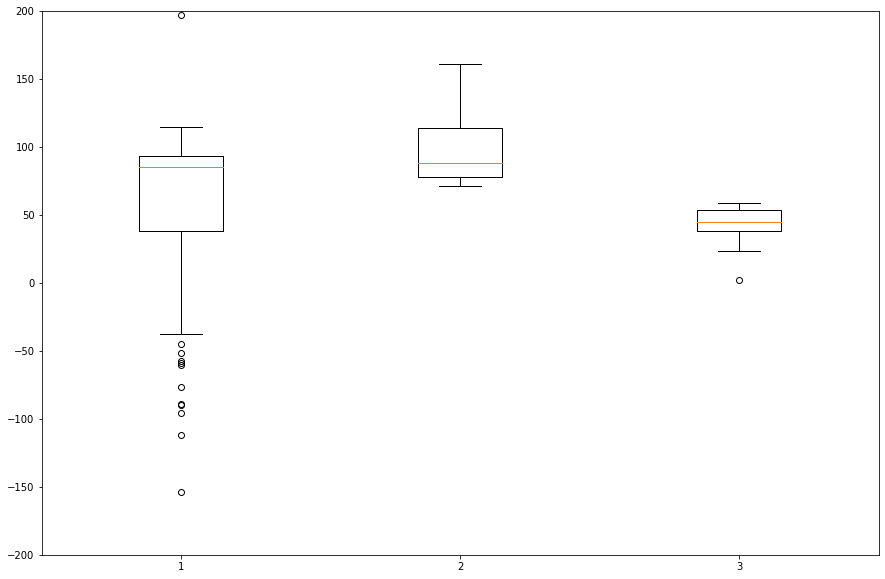

In [33]:
plt.figure(figsize=(15,10))
plt.ylim(-200,200)

plt.boxplot(results.groupby('engine_type')['prediction'].apply(list));

#### 4.3. Vitesse de décroissance de la marge EGT par type de moteur

La pente de la marge EGT correspond à sa vitesse de décroissance par cycle.

1. Quelle est son unité ?
2. Représentez ces valeurs par type de moteur sur un boxplot. Décrivez le résultat obtenu.
3. Calculez moyenne de la pente par type de moteur. Quel type de moteur a la plus faible vitesse de décroissance et donc la plus faible vitesse d'usure ?

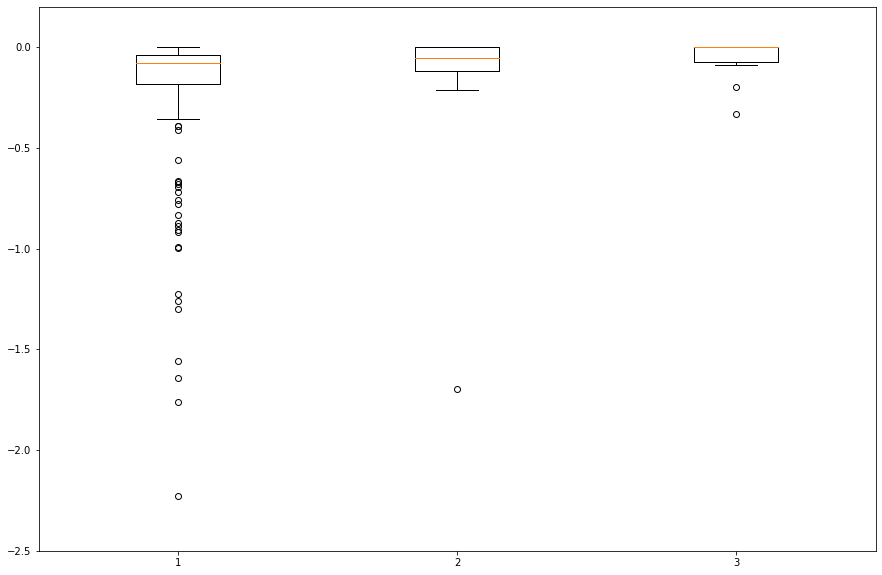

In [34]:
plt.figure(figsize=(15,10))
plt.ylim(-2.5,0.2)
plt.boxplot(results.groupby('engine_type')['coef'].apply(list));